In [79]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

models_path="dataset/models/"
scenes_path="dataset/scenes/"

products_B={i:f"{models_path}ref{i}.png" for i in range(15,28)}

scenes_B={i:f"{scenes_path}scene{i}.png" for i in range(6,13)}

In [80]:
img_shapes = {
    6: (1072, 1514),
    7: (766, 1146),
    8: (1014, 1504),
    9: (662, 1488),
    10: (932, 1696),
    11: (674, 1482),
    12: (704, 1626),
}

positions = {
    8: {
        'c': [10, 450, 820, 1160, img_shapes[8][1]],
        'r': [180, img_shapes[8][0]]
    },
    9: {
        'c': [0, 230, 490, 730, 970, 1230, 1470],
        'r': [150, img_shapes[9][0]]
    },
    10: {
        'c': [580, 840, 1120, 1390, 1650],
        'r': [200, 850]
    },
    11: {
        'c': [70, 255, 450, 650, 840, 1035, 1240, 1440],
        'r': [120, 620]
    },
    12: {
        'c': [0, 280, 560, 815, 1080, 1350, 1610],
        'r': [150, 150+570]
    },
}
positions2 = {
    12: {
        'c': [(4, 232),(320, 548),(563,807), (843, 1087),(1110, 1354),(1349, 1593)],
        'r': [(124,704),(122,702),(57,57+606),(19,19+606),(39,39+606),(31,31+606)]
    },
}

checks = {
    8: {
        0:[18,26,27],1:[17,23,24],2:[17,23,24],3:[17,23,24]
    },
    9: {
        0:[18,20,26,27],1:[18,20,26,27],2:[18,19,26,27],3:[18,19,26,27],4:[20],5:[20]
    },
    10: {
        0: [21,22,23], 1: [21,22,23], 2: [21,22,23], 3: [21,22,23]
    },
    11: {
        0: [17,23,24], 1: [17,23,24], 2: [17,23,24], 3: [17,23,24],4:[25],5:[25],6:[25]
    },
    12: {
        0:[18,26,27],1:[18,26,27],2:[18,26,27],3:[18,26,27],4:[18,26,27],5:[18,26,27]
    },
}

true = {
    8: {
        0: 27, 1: 23, 2: 23, 3: 24
    },
    9: {
        0: 18, 1: 18, 2: 19, 3: 19, 4: 20, 5: 20
    },
    10: {
        0: 21, 1: 21, 2: 22, 3: 22
    },
    11: {
        0: 23, 1: 23, 2: 24, 3: 24, 4: 25, 5: 25, 6: 25
    },
    12: {
        0: 26, 1: 26, 2: 27, 3: 27, 4: 18, 5: 18
    }
}

In [81]:
product_images={}
for product in products_B:
    product_images[product]=cv2.imread(products_B[product])

In [82]:
def denoise_image(image, filters):
    for filter in filters:
        for _ in range(filter['n_iter']):
            match filter['name']:
                case "mean":
                    '''
                    {"ksize" : 15}
                    '''
                    k_size = filter['params']['ksize']
                    mean_kernel = np.ones([k_size, k_size])/(k_size**2)
                    image = cv2.filter2D(image, -1, mean_kernel)

                case "median":
                    '''
                    {"ksize" : 11}
                    '''
                    image = cv2.medianBlur(image, **filter['params'])

                case "bilateral":
                    '''
                    {"d" : 3,
                    "sigmaColor" : 2,
                    "sigmaSpace" : 1.5}
                    '''
                    image = cv2.bilateralFilter(image, **filter['params'])

                case 'gaussian':
                    '''
                    {"sigmaX" : 2}
                    '''
                    sigmaX = filter['params']['sigmaX']
                    ksize = 2*int(np.ceil(3*sigmaX)) + 1
                    image = cv2.GaussianBlur(image, (ksize, ksize), sigmaX)

                case 'non_local_means':
                    '''
                    {'templateWindowSize':5,"searchWindowSize":21, "h":3, "hColor": 20}
                    '''
                    image = cv2.fastNlMeansDenoisingColored(image, **filter['params'])

                case 'canny':
                    '''
                    {'threshold1':5,"threshold2":21}
                    '''
                    image = cv2.Canny(image, **filter['params'])

                case 'sharpen':
                    kernel = np.array([[0, -1, 0],
                                       [-1, 5, -1],
                                       [0, -1, 0]])
                    image = cv2.filter2D(image, -1, kernel=kernel)

                case 'emboss':
                    kernel = np.array([[-2, -1, 0],
                                       [-1, 1, 1],
                                       [0, 1, 2]])
                    image = cv2.filter2D(image, -1, kernel=kernel)
                case _: pass
    return image

def normalize(image):
    return (image.astype(float)*255.0/225).astype('uint8')

filters = [
    {'name': "median",
        "n_iter": 1,
        "params": {"ksize": 3}
     },
    {'name': "median",
        "n_iter": 0,
        "params": {"ksize": 5}
     },
    {'name': "median",
        "n_iter": 1,
        "params": {"ksize": 7}
     },
    {'name': "median",
        "n_iter": 0,
        "params": {"ksize": 9}
     },
]

In [83]:
def  normalize2(image):
    # Calculate new values through linear interpolation
    max_value = np.max(image)
    new_image = np.interp(image, (0, max_value), (0, 255)).astype('uint8')
    return new_image

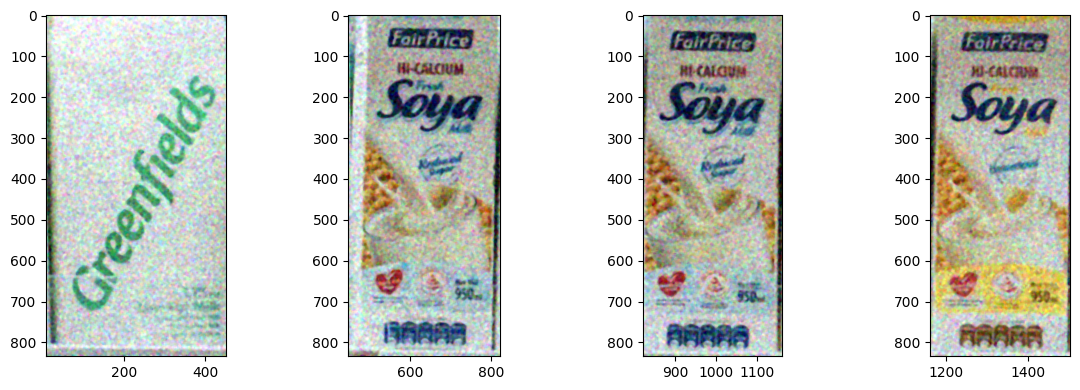

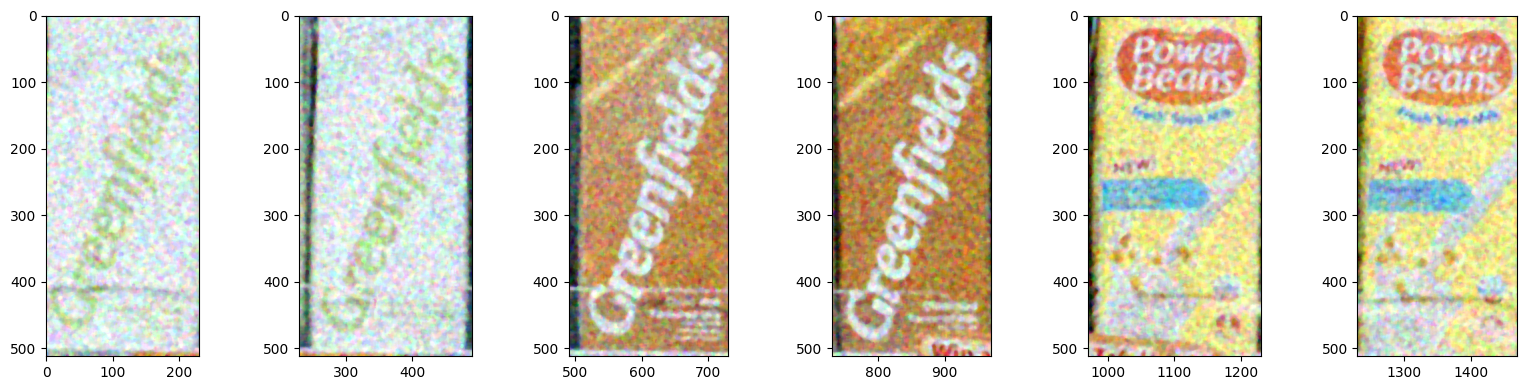

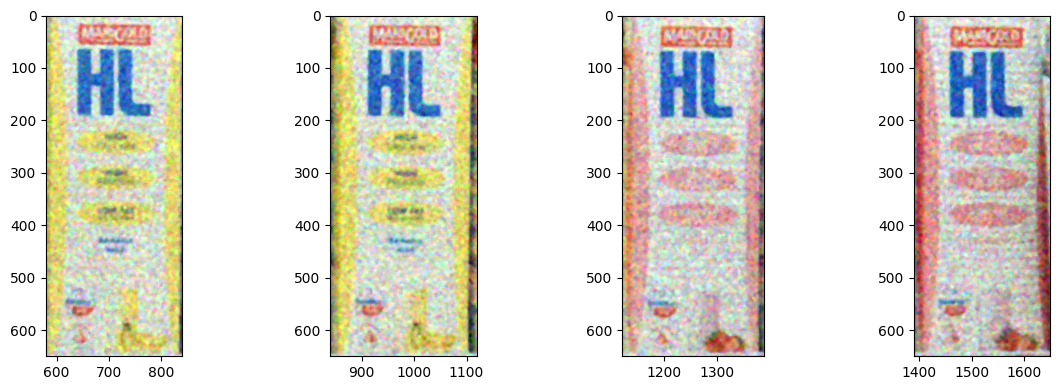

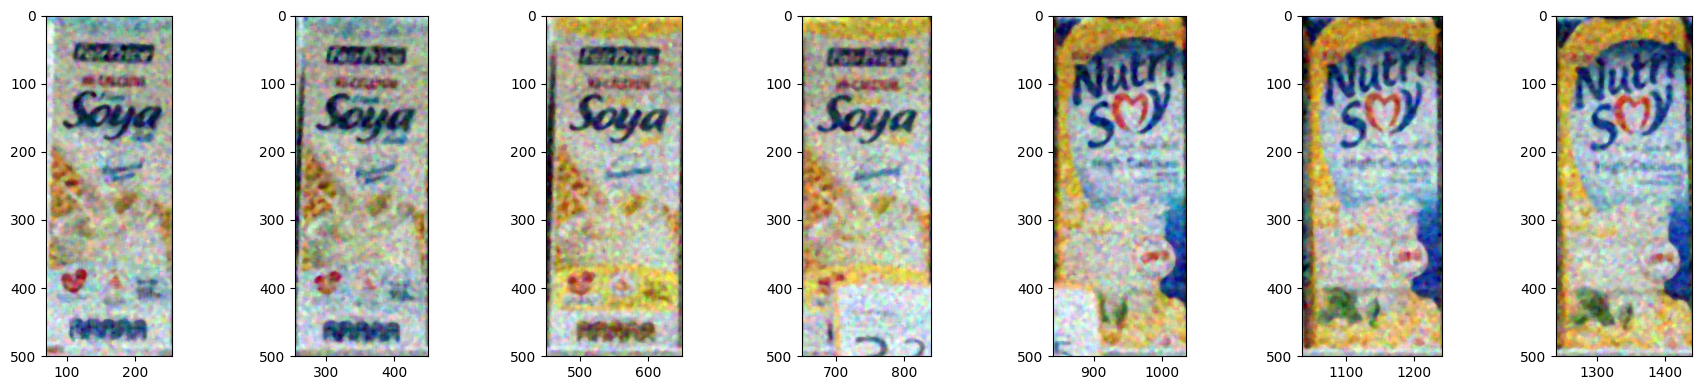

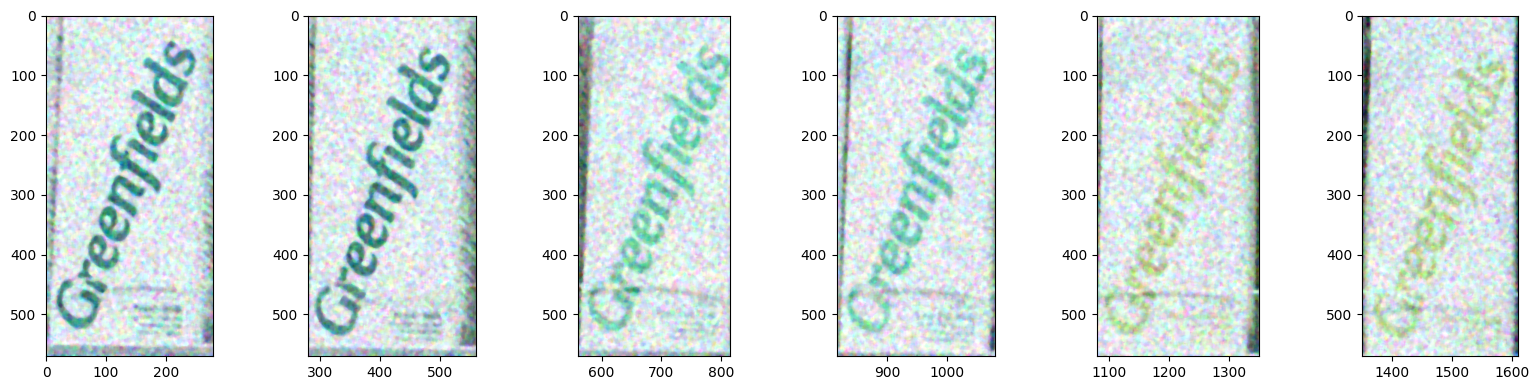

In [84]:
scene_images={}
for scene in positions:
    fig, axes = plt.subplots(1, len(positions[scene]['c'])-1, figsize=(2+2*len(positions[scene]['c']), 4),squeeze=False)
    axes = axes.flatten()

    image=cv2.imread(scenes_B[scene])
    image=denoise_image(image,filters)
    image=normalize2(image)
    l=positions[scene]['c'][0]
    r1,r2=positions[scene]['r']
    scene_images[scene]={}
    for i,r in enumerate(positions[scene]['c'][1:]):
        scene_images[scene][i]=image[r1:r2,l:r].copy()
        axes[i].imshow(image[r1:r2,l:r,::-1],extent=[l,r,r2-r1,0],aspect='equal')
        l=r

    plt.tight_layout()
    plt.show()

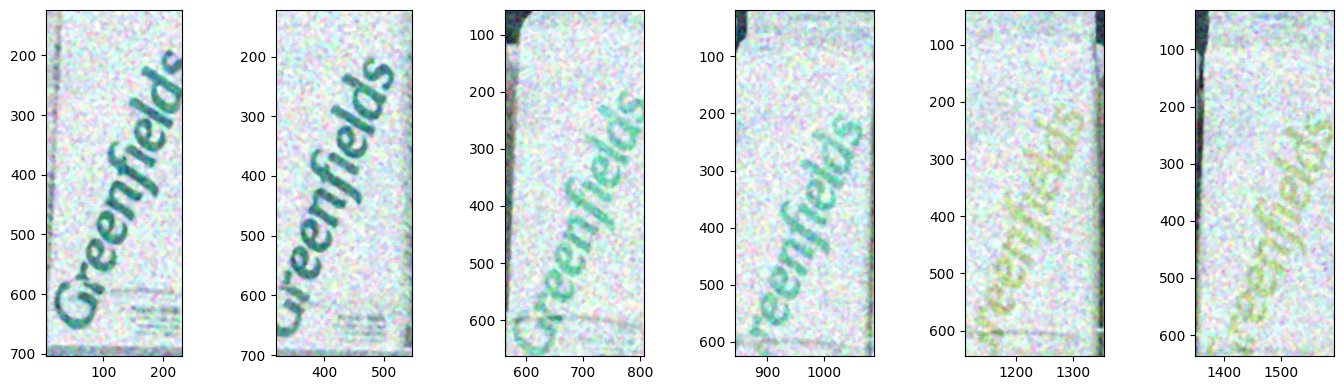

In [85]:
scene_images2={}
for scene in positions2:
    fig, axes = plt.subplots(1, len(positions2[scene]['c']), figsize=(2+2*len(positions2[scene]['c']), 4),squeeze=False)
    axes = axes.flatten()

    image=cv2.imread(scenes_B[scene])
    image=denoise_image(image,filters)
    image=normalize2(image)
    scene_images2[scene]={}
    for i in range(len(positions2[scene]['c'])):
        l,r=positions2[scene]['c'][i]
        u,d=positions2[scene]['r'][i]
        scene_images2[scene][i]=image[u:d,l:r]
        axes[i].imshow(image[u:d,l:r,::-1],extent=[l,r,d,u],aspect='equal')

    plt.tight_layout()
    plt.show()

In [86]:
def disturb_image(product,value,type):
    noise=0
    match type:
        case 'randint':
            noise=np.random.randint(-value,value,product_images[product].shape)+value
        case 'normal':
            noise=np.random.normal(scale=value,size=product_images[product].shape)
        case _: 
            return product_images[product]
    return np.clip(product_images[product]-noise,0,225).astype(np.uint8)

In [87]:
def compute_color_similarity(ref, scene):
    sceneR=scene[:,:,0]
    sceneG=scene[:,:,1]
    sceneB=scene[:,:,2]
    sceneR = cv2.resize(sceneR,(ref.shape[1],ref.shape[0]),None, cv2.INTER_LINEAR)
    sceneG = cv2.resize(sceneG,(ref.shape[1],ref.shape[0]),None, cv2.INTER_LINEAR)
    sceneB = cv2.resize(sceneB,(ref.shape[1],ref.shape[0]),None, cv2.INTER_LINEAR)
    scene=np.stack((sceneR,sceneG,sceneB),axis=-1)
    pixel_euclidean = np.linalg.norm(ref - scene)
    pixel_manhattan = np.sum(np.abs(ref - scene))
    pixel_cosine = np.dot(ref.flatten(), scene.flatten()) / (np.linalg.norm(ref) * np.linalg.norm(scene))
    
    # Compute histogram comparison metrics
    hist1 = cv2.calcHist([ref], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.calcHist([scene], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256])
    hist_intersection = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    hist_chi_squared = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    hist_bhattacharyya = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)
    
    # Print results
    # print("Pixel-wise Comparison:")
    # print("Euclidean distance:", pixel_euclidean)
    # print("Manhattan distance:", pixel_manhattan)
    # print("Cosine similarity:", pixel_cosine)
    # print("\nHistogram Comparison:")
    # print("Histogram Intersection:", hist_intersection)
    # print("Chi-Squared distance:", hist_chi_squared)
    # print("Bhattacharyya distance:", hist_bhattacharyya)
    return pixel_euclidean,pixel_manhattan,pixel_cosine,hist_intersection,hist_chi_squared,hist_bhattacharyya

In [88]:
VALUE=75
res={}
for scene in scene_images:
    res[scene]={}
    for i,slice in enumerate(scene_images[scene]):
        res[scene][i]={}
        # print(scene_images[scene][slice].shape)
        # mean_slice=np.mean(scene_images[scene][slice])
        for product in checks[scene][i]:
            scn=scene_images[scene][i]
            prod=product_images[product] #da ridimensionare
            # prod=cv2.resize(prod,(scn.shape[1],scn.shape[0]),interpolation=1)
            res[scene][i][product]=compute_color_similarity(prod,scn)


In [89]:
display(res)

{8: {0: {18: (164041.2113951857,
    138607298,
    3.5813250033108236e-09,
    93016.0,
    79407300.98945613,
    0.786155464058511),
   26: (148689.276627469,
    120081592,
    3.2313122244277213e-09,
    70169.0,
    29886561.84218445,
    0.7838511867847524),
   27: (155445.73126014107,
    129244351,
    3.518326226861579e-09,
    96823.0,
    32821771.897917345,
    0.7570804929231241)},
  1: {17: (145273.97049024302,
    107114384,
    4.775459317540963e-10,
    113658.0,
    2982482.676198347,
    0.572659096771323),
   23: (165868.96452320428,
    139501016,
    4.5394367316651575e-09,
    140870.0,
    8313180.2496823585,
    0.5859330763614076),
   24: (153457.16895928973,
    124756905,
    3.235658975934526e-09,
    113843.0,
    14647669.667131621,
    0.6552759518386416)},
  2: {17: (139446.61337945788,
    98299699,
    3.8809771139311685e-09,
    115343.0,
    2526670.755027385,
    0.5619539003020517),
   23: (160470.8688391759,
    130171198,
    3.1705687258407457

In [90]:
VALUE=75
res2={}
for scene in scene_images2:
    res2[scene]={}
    for i,slice in enumerate(scene_images2[scene]):
        res2[scene][i]={}
        for product in checks[scene][i]:
            scn=scene_images2[scene][i]
            prod=product_images[product]
            res2[scene][i][product]=compute_color_similarity(prod,scn)

In [91]:
display(res2)

{12: {0: {18: (198990.08234834217,
    186111529,
    2.0836624003300026e-09,
    79909.0,
    381734864.59599936,
    0.7846724352480101),
   26: (179459.8714671333,
    155919677,
    1.2236207400598097e-09,
    111404.0,
    16186260.716921207,
    0.6982478338313232),
   27: (190186.46871425948,
    174018580,
    8.327368042622142e-10,
    108641.0,
    16334571.819503512,
    0.7168884689854699)},
  1: {18: (194693.44703148075,
    179857997,
    3.455591291069817e-09,
    81215.0,
    278944278.4824832,
    0.7825422358795454),
   26: (175158.02454926237,
    151420270,
    1.1304863308000721e-09,
    109331.0,
    15485647.701753188,
    0.7032214742766318),
   27: (186018.69308754968,
    168385728,
    2.2873260296136054e-09,
    111097.0,
    18375603.143133312,
    0.7185349808503902)},
  2: {18: (202175.04060837976,
    189422463,
    1.2875872290883638e-09,
    78692.0,
    430317889.83334357,
    0.7887654091923783),
   26: (179781.45556202397,
    157965362,
    9.38823

In [92]:
metrics=[*range(6)] # da 0 a 5
names={
0:'pixel_euclidean',
1:'pixel_manhattan',
2:'pixel_cosine',
3:'hist_intersection',
4:'hist_chi_squared',
5:'hist_bhattacharyya'}
for scene in res2:
    print(f'scene {scene}:')
    for slice in res2[scene]:
        print(f'\tslice {slice} (true:{true[scene][slice]}):')
        for i in metrics:
            vals=[res2[scene][slice][product][i] for product in res2[scene][slice]]
            max_value = max(vals)
            max_index = vals.index(max_value)
            keys=list(res2[scene][slice].keys())
            print(f'\t\tmetric {names[i]}, prod found: {keys[max_index]} ({max_value})')


scene 12:
	slice 0 (true:26):
		metric pixel_euclidean, prod found: 18 (198990.08234834217)
		metric pixel_manhattan, prod found: 18 (186111529)
		metric pixel_cosine, prod found: 18 (2.0836624003300026e-09)
		metric hist_intersection, prod found: 26 (111404.0)
		metric hist_chi_squared, prod found: 18 (381734864.59599936)
		metric hist_bhattacharyya, prod found: 18 (0.7846724352480101)
	slice 1 (true:26):
		metric pixel_euclidean, prod found: 18 (194693.44703148075)
		metric pixel_manhattan, prod found: 18 (179857997)
		metric pixel_cosine, prod found: 18 (3.455591291069817e-09)
		metric hist_intersection, prod found: 27 (111097.0)
		metric hist_chi_squared, prod found: 18 (278944278.4824832)
		metric hist_bhattacharyya, prod found: 18 (0.7825422358795454)
	slice 2 (true:27):
		metric pixel_euclidean, prod found: 18 (202175.04060837976)
		metric pixel_manhattan, prod found: 18 (189422463)
		metric pixel_cosine, prod found: 27 (3.5766601635639493e-09)
		metric hist_intersection, prod f

In [93]:
metrics=[*range(6)] # da 0 a 5
for scene in res2:
    print(f'scene {scene}:')
    for i in metrics:
        print(f'\tmetric {names[i]}:')
        for slice in res2[scene]:
            vals=[res2[scene][slice][product][i] for product in res2[scene][slice]]
            max_value = max(vals)
            max_index = vals.index(max_value)
            keys=list(res2[scene][slice].keys())
            print(f'\t\tinstance_{slice}, prod found: {keys[max_index]} ({max_value})')


scene 12:
	metric pixel_euclidean:
		instance_0, prod found: 18 (198990.08234834217)
		instance_1, prod found: 18 (194693.44703148075)
		instance_2, prod found: 18 (202175.04060837976)
		instance_3, prod found: 18 (200005.72617802722)
		instance_4, prod found: 18 (196746.14075757624)
		instance_5, prod found: 18 (196605.70155008222)
	metric pixel_manhattan:
		instance_0, prod found: 18 (186111529)
		instance_1, prod found: 18 (179857997)
		instance_2, prod found: 18 (189422463)
		instance_3, prod found: 18 (184469764)
		instance_4, prod found: 18 (178916955)
		instance_5, prod found: 18 (179708200)
	metric pixel_cosine:
		instance_0, prod found: 18 (2.0836624003300026e-09)
		instance_1, prod found: 18 (3.455591291069817e-09)
		instance_2, prod found: 27 (3.5766601635639493e-09)
		instance_3, prod found: 18 (1.585674002102158e-09)
		instance_4, prod found: 18 (3.520393581434197e-09)
		instance_5, prod found: 26 (2.929657781090012e-09)
	metric hist_intersection:
		instance_0, prod found:

In [94]:
# def check_smallest(res):
#     for scene in res:
#         print(f'scene {scene}')
#         for index, data in res[scene].items():
#             smallest_key = min(data.keys(), key=lambda k: data[k])
#             print(f"product {index+1}, best color: {smallest_key} ({res[scene][index][smallest_key]:.3f})")

# check_smallest(res)